In [8]:
import os
import datetime

#图像读取库
from PIL import Image
#矩阵运算库
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 分类
label_names = ["anger", "disgust", "fear", "happy", "sad"]
label_to_index = dict((name, index) for index, name in enumerate(label_names))

print(label_names)
print(label_to_index)

['anger', 'disgust', 'fear', 'happy', 'sad']
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4}


In [10]:
# 获取训练的图片列表和分类标签信息
def load_images(data_dir):
    fpaths = []
    labels = []
    
    for label in os.listdir(data_dir):
        labelPath = os.path.join(data_dir, label)
        for fname in os.listdir(labelPath):
            # 文件名
            fpath = os.path.join(labelPath, fname)
            fpaths.append(fpath)
            
            # 标签
            labels.append(label_to_index[label])
    
    # 将图片名和标签 打包成一组，然后进行乱序
    temp = np.array([fpaths,labels])
    temp = temp.transpose()
    np.random.shuffle(temp)

    fpaths = list(temp[:,0])
    labels = list(temp[:,1])
    labels = [int(i) for i in labels]
    
    return fpaths, labels

In [11]:
# 数据文件夹
data_dir = "/home/wilson/workstation/TFResFaceEmotion/emotions"

all_image_paths, all_image_labels = load_images(data_dir)

image_count = len(all_image_paths)
print("total", image_count, "images")

total 80 images


In [12]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    image = (image - 0.0)/255.0 # 归一化mean=0， std=255
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [13]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

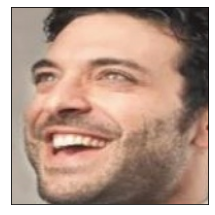

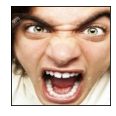

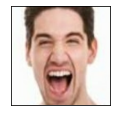

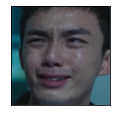

In [13]:
import matplotlib.pyplot as plt

# 预览前几张图片
plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    image *= 255  # 将图片放大到 [0,255]才能显示颜色，否则是黑色
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [14]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(4):
    print(label_names[label.numpy()])

happy
anger
happy
sad


In [15]:
# 由于这些数据集顺序相同，你可以将他们打包在一起得到一个(图片, 标签)对数据集：
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
image_label_ds = ds.map(load_and_preprocess_from_path_label)
print(image_label_ds)

<ZipDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int32)>


/home/wilson/workstation/TFResFaceEmotion/emotions/happy/happy (22).jpg



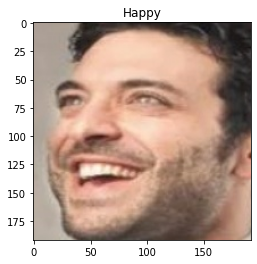

In [16]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

print(image_path)
plt.imshow(load_and_preprocess_image(image_path) * 255) # 将图片放大到 [0,255]才能显示颜色，否则是黑色
plt.grid(False)
plt.title(label_names[label].title())
print()

In [17]:
"""训练的基本方法
要使用此数据集训练模型，你将会想要数据：

    被充分打乱。
    被分割为 batch。
    永远重复。
    尽快提供 batch。

使用 tf.data api 可以轻松添加这些功能。
"""
BATCH_SIZE = 16

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>


In [18]:
# 现在准备分类模型
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

In [19]:
# 该模型期望它的输出被标准化至 [-1,1] 范围内：
# 这只是一个打印辅助函数，说明preprocess_input 是如何工作的，例如他自动会将最大输入范围[0,255] 调整为[-1, 1], 而非需要我们自己
#  提前转换成[-1, 1]
help(tf.keras.applications.mobilenet_v2.preprocess_input)


Help on function preprocess_input in module tensorflow.python.keras.applications.mobilenet_v2:

preprocess_input(x, data_format=None)
    Preprocesses a tensor or Numpy array encoding a batch of images.
    
    Usage example with `applications.MobileNet`:
    
    ```python
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet()
    x = core(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    image = tf.image.decode_png(tf.io.read_file('file.png'))
    result = model(image)
    ```
    
    Arguments:
      x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
        channels, with values in the range [0, 255].
        The preprocessed data are written over the input data
        if the data types are compatible. To avoid this
        behaviour, `numpy.copy(x)` can be used.
      data_format: Optional data for

In [20]:
# 在你将输出传递给 MobilNet 模型之前，你需要将其范围从 [0,1] 转化为 [-1,1]：
# 只是为了预览数据，查看模型的中间数据结构而已，对实际的输入数据ds是没有做处理的
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(16, 6, 6, 1280)


In [21]:
# 模型保存位置
model_save_path = 'emotion.model'

# 模型
model = None
if os.path.exists(model_save_path):
    model = keras.models.load_model(model_save_path)
    print("existing model will be load in:", model_save_path)
else:
    print("will create new model")
    model = tf.keras.Sequential([
        mobile_net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(label_names), activation='softmax')])

existing model will be load in: emotion.model


In [22]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 2.3369283e-08
max logit: 0.9999882

Shape: (16, 5)


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])


In [24]:
len(model.trainable_variables)


158

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [26]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
print(steps_per_epoch)

5.0


In [27]:
# Clear any logs from previous runs
# 清除旧的log
#!rm -rf ./logs/

# 日志统计回调
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard 回调
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=100)
# 快照回调
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join('checkpoints', "model_mobilenetV2_x75_{epoch:03d}-{accuracy:.4f}.checkpoint"),
    verbose=1, 
    save_weights_only=False, 
    mode='auto',                                            
    save_freq=10000)

In [28]:
# 执行训练
# 考虑一个一批处理少量的图片，不太合理，再次可进行手工调整
steps_per_epoch = 1000
model.fit(ds, epochs=10, steps_per_epoch=steps_per_epoch, 
         callbacks=[tensorboard_callback, checkpoint_callback])
print("train done.")

# 保存模型
model.save(model_save_path)

Epoch 1/10
   1/1000 [..............................] - ETA: 0s - loss: 6.5489e-06 - accuracy: 1.0000WARNING:tensorflow:From /home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0042 - accuracy: 0.9987
Epoch 2/10
1000/1000 [==============================] - 55s 55ms/step - loss: 1.4505e-04 - accuracy: 1.0000
Epoch 3/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0091 - accuracy: 0.9980
Epoch 4/10
1000/1000 [==============================] - 55s 55ms/step - loss: 2.0363e-05 - accuracy: 1.0000
Epoch 5/10
1000/1000 [==============================] - 55s 55ms/step - loss: 5.6600e-06 - accuracy: 1.0000
Epoch 6/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0096 - accu

In [29]:
# 如果出现 UsageError: Line magic function `%tensorboard` not found.
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [14]:
# 进行校验
import tensorflow as tf
import os
import numpy as np

# 从概率列表里，获取分类
def get_category_from_possiable(possiables):
    index = 0
    maxPoss = 0.0
    for k in range(len(possiables)):
        if possiables[k] > maxPoss:
            index = k
            maxPoss = possiables[k]
    return index

def testValidate():
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    # 分类
    label_names = ["anger", "disgust", "fear", "happy", "sad"]
    label_to_index = dict((name, index) for index, name in enumerate(label_names))
    
    print(label_names)
    print(label_to_index)
    
    # 准备测试数据
    data_dir = "/home/wilson/workstation/TFResFaceEmotion/emotions"
    
    all_image_paths, all_image_labels = load_images(data_dir)
    print("all_image_lavels", len(all_image_labels))
    print("all_image_paths", len(all_image_paths))
    
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    final_ds = image_ds.batch(1)
    
    predict = model.predict(final_ds)
    correct = 0
    for k in range(len(predict)):
        category = get_category_from_possiable(predict[k])
        if category == all_image_labels[k]:
            correct += 1
            print("predict: [{} {}/{}] {}".format(category, label_names[category], label_names[all_image_labels[k]], all_image_paths[k]))
        else:
            print("!!! predict: [{} {}/{}] {}".format(category, label_names[category], label_names[all_image_labels[k]], all_image_paths[k]))
    print("correct {} {}/{}".format(correct/len(predict), correct, len(predict)))
    
# 调用进行测试
testValidate()

['anger', 'disgust', 'fear', 'happy', 'sad']
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4}
all_image_lavels 80
all_image_paths 80
predict: [0 anger/anger] /home/wilson/workstation/TFResFaceEmotion/emotions/anger/anger (6).jpg
predict: [4 sad/sad] /home/wilson/workstation/TFResFaceEmotion/emotions/sad/sad (27).jpg
predict: [1 disgust/disgust] /home/wilson/workstation/TFResFaceEmotion/emotions/disgust/disgust (1).jpg
predict: [4 sad/sad] /home/wilson/workstation/TFResFaceEmotion/emotions/sad/sad (18).jpg
predict: [3 happy/happy] /home/wilson/workstation/TFResFaceEmotion/emotions/happy/happy (11).jpg
predict: [4 sad/sad] /home/wilson/workstation/TFResFaceEmotion/emotions/sad/sad (4).jpg
predict: [0 anger/anger] /home/wilson/workstation/TFResFaceEmotion/emotions/anger/anger (5).jpg
predict: [2 fear/fear] /home/wilson/workstation/TFResFaceEmotion/emotions/fear/fear (4).jpg
predict: [0 anger/anger] /home/wilson/workstation/TFResFaceEmotion/emotions/anger/anger (24).jpg
predict:

In [33]:
#savedModel 保存为 TFLite
import tensorflow as tf

def convert_my_saved_model_to_tflite(savedPath, tflite_path):
    saved_model_to_tflite_converter = tf.lite.TFLiteConverter.from_saved_model(savedPath)
    #量化tflite 模型，可以在损失较小精度或不影响精度的情况下减小模型大小
    saved_model_to_tflite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    saved_model_tflite = saved_model_to_tflite_converter.convert()
    with open(tflite_path, 'wb') as f:
        f.write(saved_model_tflite)  
        
savedPath = 'emotion.model.mobilenetV2_x75_1.00_20200913'
tflitePath = 'emotion.model.mobilenetV2_x75_1.00_20200913.tflite'
convert_my_saved_model_to_tflite(savedPath, tflitePath)

In [1]:
#saveModel 保存为带签名的可发布
import os
import tensorflow as tf
from tensorflow import keras

# @param savedModelPath  加载已经训练好的 基础Savedmodel模型地址
# @param export_path_base 需要导出的目的地
# @param export_version   导出的版本号
def saveAsPublishServer(savedModelPath, export_path_base, export_version):
    tf.compat.v1.disable_eager_execution()
    sess = tf.compat.v1.Session()
    
    # 加载已经训练好的 基础Savedmodel模型
    savedModel = keras.models.load_model(savedModelPath)
    print("input meta :")
    print(savedModel.input)
    print()
    
    print("output meta:")
    print(savedModel.output)
    print()
    
    legacy_init_op = tf.group(tf.compat.v1.tables_initializer())
    
    # 输入张量
    input_tensor = savedModel.input[0]
    input_tensor_info = tf.compat.v1.saved_model.utils.build_tensor_info(input_tensor)
    
    # 输出张量
    output_tensor = savedModel.output[0]
    output_tensor_info = tf.compat.v1.saved_model.utils.build_tensor_info(output_tensor)
    
    # 构建导出签名
    classification_signature = (
        tf.compat.v1.saved_model.signature_def_utils.build_signature_def(
            inputs = {'image':input_tensor_info},
            outputs = {'possibilities':output_tensor_info},
            method_name = tf.compat.v1.saved_model.signature_constants.CLASSIFY_METHOD_NAME))
    
    export_path = os.path.join(
        tf.compat.as_bytes(export_path_base),
        tf.compat.as_bytes(str(export_version)))
    print("Exporting trained model to", export_path)
    
    builder = tf.compat.v1.saved_model.builder.SavedModelBuilder(export_path)
    builder.add_meta_graph_and_variables(
        sess, 
        [tf.compat.v1.saved_model.tag_constants.SERVING],
        signature_def_map = {
            tf.compat.v1.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                classification_signature
        },
        main_op=legacy_init_op
    )
    builderl.save()
    
    print("Export Done")

saveAsPublishServer('emotion.model', 'emotion.model.servable', 1)

input meta :
Tensor("mobilenetv2_1.00_192_input:0", shape=(None, 192, 192, 3), dtype=float32)

output meta:
Tensor("dense_1/Softmax:0", shape=(None, 5), dtype=float32)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
Exporting trained model to b'emotion.model.servable/1'
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.


FailedPreconditionError: Error while reading resource variable block_11_depthwise_BN/beta/m from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/block_11_depthwise_BN/beta/m)
	 [[node block_11_depthwise_BN/beta/m/Read/ReadVariableOp (defined at <ipython-input-1-8a6fbc5d129e>:14) ]]

Original stack trace for 'block_11_depthwise_BN/beta/m/Read/ReadVariableOp':
  File "/usr/lib/python3.8/runpy.py", line 193, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 838, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.8/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 543, in execute_request
    self.do_execute(
  File "/usr/local/lib/python3.8/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2876, in run_cell
    result = self._run_cell(
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3145, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-8a6fbc5d129e>", line 59, in <module>
    saveAsPublishServer('emotion.model', 'emotion.model.servable', 1)
  File "<ipython-input-1-8a6fbc5d129e>", line 14, in saveAsPublishServer
    savedModel = keras.models.load_model(savedModelPath)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/keras/saving/save.py", line 187, in load_model
    return saved_model_load.load(filepath, compile, options)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/keras/saving/saved_model/load.py", line 120, in load
    model = tf_load.load_internal(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/load.py", line 632, in load_internal
    loader = loader_cls(object_graph_proto, saved_model_proto, export_dir,
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/keras/saving/saved_model/load.py", line 194, in __init__
    super(KerasObjectLoader, self).__init__(*args, **kwargs)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/load.py", line 130, in __init__
    self._load_all()
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/keras/saving/saved_model/load.py", line 218, in _load_all
    super(KerasObjectLoader, self)._load_all()
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/load.py", line 141, in _load_all
    self._load_nodes()
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/saved_model/load.py", line 294, in _load_nodes
    slot_variable = optimizer_object.add_slot(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py", line 760, in add_slot
    weight = tf_variables.Variable(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/variables.py", line 262, in __call__
    return cls._variable_v2_call(*args, **kwargs)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/variables.py", line 244, in _variable_v2_call
    return previous_getter(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/variables.py", line 237, in <lambda>
    previous_getter = lambda **kws: default_variable_creator_v2(None, **kws)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/variable_scope.py", line 2633, in default_variable_creator_v2
    return resource_variable_ops.ResourceVariable(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/variables.py", line 264, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1507, in __init__
    self._init_from_args(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 1701, in _init_from_args
    value = gen_resource_variable_ops.read_variable_op(handle, dtype)
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 490, in read_variable_op
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 742, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3477, in _create_op_internal
    ret = Operation(
  File "/home/wilson/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1949, in __init__
    self._traceback = tf_stack.extract_stack()


In [2]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow import keras

# 分类
label_names = ["anger", "disgust", "fear", "happy", "sad"]
label_to_index = dict((name, index) for index, name in enumerate(label_names))

# 从概率列表里，获取分类
def get_category_from_possiable(possiables):
    index = 0
    maxPoss = 0.0
    for k in range(len(possiables)):
        if possiables[k] > maxPoss:
            index = k
            maxPoss = possiables[k]
    return index, maxPoss

# 预处理图片
def preprocess_image(image):
    fixedImg = tf.image.decode_jpeg(image, channels=3)
    fixedImg = tf.image.convert_image_dtype(fixedImg,dtype=tf.float32)
    fixedImg = (fixedImg - 0.0)/255.0 # 归一化mean=0， std=255
    return fixedImg

# 进行分类
# @param iamgeData 尺寸为192*192 的图片
def classify_image(model, imageData):
    fixedImage = preprocess_image(imageData)
    print("fixedImage", fixedImage)
    inputBatch = fixedImage[np.newaxis, ...]
    predict = model.predict(inputBatch)
    possiables = predict[0]
    category, confidence = get_category_from_possiable(possiables)
    return category, confidence

imagePath = '/home/wilson/workstation/TFResFaceEmotion/emotions/happy/happy_11.jpg'
imageData = tf.io.read_file(imagePath)

# 加载模型
model = keras.models.load_model('emotion.model.mobilenetV2_x75_1.00_20200913')

category, confidence = classify_image(model, imageData)
print("result:", category, confidence)


fixedImage tf.Tensor(
[[[2.0915035e-03 1.5840062e-03 9.5347950e-04]
  [2.1530183e-03 1.6455211e-03 1.0149943e-03]
  [2.1837757e-03 1.7070359e-03 1.0303730e-03]
  ...
  [5.0749717e-04 4.1522496e-04 2.3068053e-04]
  [4.6136105e-04 4.1522496e-04 1.8454442e-04]
  [4.6136105e-04 4.1522496e-04 1.8454442e-04]]

 [[2.1222609e-03 1.6147636e-03 9.8423695e-04]
  [2.1530183e-03 1.6455211e-03 1.0149943e-03]
  [2.1837757e-03 1.7070359e-03 1.0303730e-03]
  ...
  [4.9211847e-04 3.9984623e-04 2.1530183e-04]
  [4.4598235e-04 3.9984623e-04 1.6916571e-04]
  [4.4598235e-04 3.9984623e-04 1.6916571e-04]]

 [[2.1068822e-03 1.5993849e-03 9.3810080e-04]
  [2.1530183e-03 1.6455211e-03 9.8423695e-04]
  [2.1837757e-03 1.6762785e-03 1.0149943e-03]
  ...
  [4.9211847e-04 3.9984623e-04 2.1530183e-04]
  [4.6136105e-04 3.6908884e-04 1.8454442e-04]
  [4.6136105e-04 3.6908884e-04 1.8454442e-04]]

 ...

 [[2.9219533e-04 2.6143793e-04 6.1514809e-05]
  [3.0757402e-04 2.7681663e-04 7.6893506e-05]
  [3.2295272e-04 2.9219533e-